<b>An interesting yet simple algorithmic approach to playing the popular 'Wordle' game recently bought by the NYT.<br>If nothing else, you will learn a lot about 5 letter words.</b><br><br>
You can play the game here - https://www.powerlanguage.co.uk/wordle/<br><br>
First, let us get a list of all possible 5 letter words.<br> I found this one on github - https://github.com/charlesreid1/five-letter-words/blob/master/sgb-words.txt

In [2]:
"""
Let's read the file into python as a list of words
"""

import requests
url = 'https://raw.githubusercontent.com/charlesreid1/five-letter-words/master/sgb-words.txt'

# Fetch the data using a HTTP request
words = requests.get(url).content.decode().split('\n')

# Just a double check to see if all words are 5 letter words. Also removes stray spaces
words = [word for word in words if len(word) == 5]

# We will call our word set a corpus because we are fancy like that
print('Corpus has {} words.'.format(len(words)))

import random
print('Preview : {}'.format(random.sample(words,100)))

Corpus has 5757 words.
Preview : ['imply', 'didot', 'agars', 'aloft', 'vigil', 'spout', 'pasta', 'prawn', 'molly', 'snoop', 'hapax', 'tamer', 'umbel', 'yokes', 'bores', 'reign', 'taros', 'bawdy', 'naiad', 'temps', 'older', 'halve', 'corer', 'youse', 'snack', 'manic', 'bebug', 'color', 'adobe', 'weals', 'rubes', 'didos', 'gangs', 'sugar', 'hitch', 'feuar', 'sides', 'chile', 'plots', 'venue', 'crept', 'grata', 'mange', 'velds', 'worst', 'happy', 'zests', 'sines', 'cupid', 'dotes', 'poohs', 'taxol', 'tided', 'rusks', 'shore', 'sprig', 'inept', 'washy', 'truss', 'serfs', 'bikes', 'whipt', 'darer', 'molar', 'bough', 'scarp', 'phyla', 'hills', 'saxes', 'faddy', 'brawn', 'hyper', 'dicks', 'locks', 'gazed', 'feast', 'inode', 'bolas', 'gouts', 'polly', 'sagas', 'manse', 'dowel', 'wheat', 'falls', 'graze', 'whiff', 'duped', 'filmy', 'bocci', 'mints', 'blunt', 'games', 'rends', 'scion', 'intro', 'might', 'clogs', 'pasts', 'frees']


<b>The essense of the algorithm - <br>
We will use simple probabilities to make guesses which eliminate maximum number of potential next guesses</b>

<b>Approach 1</b> - Don't care about positions<br>
We find the frequency of occourence of each letter in our list of words. We only check if it appears somewhere in the word, not at any particular position.

In [13]:
# Dictionary to store the frequencies
frequencies = {}

for word in words:
    for letter in word:
        # If letter already exists, increment
        if letter in frequencies: 
            frequencies[letter] += 1
        # Else, set count to 1
        else: 
            frequencies[letter] = 1
            
print(frequencies)

{'w': 505, 'h': 814, 'i': 1592, 'c': 964, 't': 1585, 'e': 3009, 'r': 1910, 'a': 2348, 'b': 715, 'o': 1915, 'u': 1089, 'l': 1586, 'd': 1181, 's': 3033, 'f': 561, 'g': 679, 'n': 1285, 'k': 596, 'y': 886, 'p': 955, 'v': 318, 'm': 843, 'q': 53, 'j': 89, 'x': 139, 'z': 135}


The above dictionary means that the letter 's' occours in 3033 words out of our 5757 words, 'w' occours in 505, etc.
So, we guess 'S' 

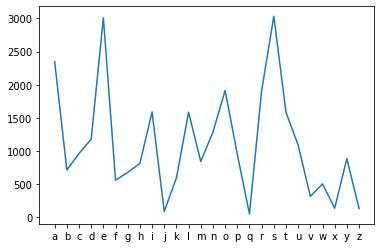

In [14]:
"""
Visualizing the data above just for the lulz
"""

import matplotlib.pylab as plt
lists = sorted(frequencies.items()) # sort alphabetically
x, y = zip(*lists)
plt.plot(x, y)
plt.show()

<b>We generate a score based on how 'disruptive' each letter in the word is<br>
Which letters should we guess?<br>
We guess the words which divide the list the most<br>
Think about it -
<li>If we guess letters which which are in only 1% (no such actual case but imagine) of the words, there's a high chance we get a GREY and we have eliminated only 1% of possible options
<li>If we guess letters which are in 99% (no such actual case but imagine) of the words, there's a high chance we get a YELLOW and we have eliminated only 1% of possible options
<li>So we give higher scores to letters whose frequencies are closest to half (50%) of the number of total words!

In [26]:
# Generating distances from halfway as TOTAL NO. OF WORDS - FREQUENCY OF WORDS IN WHICH THE LETTER OCCOURS
scores_algorithm_1 = {}
for letter in frequencies:
    scores_algorithm_1[letter] = len(words) - frequencies[letter]
# Sorting letters based on their distance from the half
print({k: v for k, v in sorted(scores_algorithm_1.items(), key=lambda item: item[1])})

{'s': 2724, 'e': 2748, 'a': 3409, 'o': 3842, 'r': 3847, 'i': 4165, 'l': 4171, 't': 4172, 'n': 4472, 'd': 4576, 'u': 4668, 'c': 4793, 'p': 4802, 'y': 4871, 'm': 4914, 'h': 4943, 'b': 5042, 'g': 5078, 'k': 5161, 'f': 5196, 'w': 5252, 'v': 5439, 'x': 5618, 'z': 5622, 'j': 5668, 'q': 5704}


<b>Does this mean 'seaor' is the best guess according to Algorithm 1?<br>
Well yes... but the game only allows valid words. So we have to use these <font color = "red">letter scores</font> to generate <font color = "red">word scores</font> for all valid words<br>
Lesser the score, better the word.

In [118]:
# Score based on overall frequency
word_scores_algorithm_1 = {}
for word in words:
    scores = scores_algorithm_1.copy()
    word_score = 0
    for letter in word:
        word_score += scores[letter]
        """
        THIS PART IS IMPORTANT!
        Currently the algorithm just tries to fit in as much high scoring letters as possible
        But we want to penalize repetition of letters because repeated letters give us less info
        So, once we have used a letter, we set its score to the max score value to penalize guesses with repetitions
        """
        scores[letter] = len(words)
    word_scores_algorithm_1[word] = word_score

# Sorting the scored words
_sorted_scores = {k: v for k, v in sorted(word_scores_algorithm_1.items(), key=lambda item: item[1])}
list(_sorted_scores.items())[:15]

[('arose', 16570),
 ('raise', 16893),
 ('arise', 16893),
 ('aloes', 16894),
 ('stoae', 16895),
 ('laser', 16899),
 ('earls', 16899),
 ('reals', 16899),
 ('tears', 16900),
 ('rates', 16900),
 ('stare', 16900),
 ('aster', 16900),
 ('tares', 16900),
 ('snare', 17200),
 ('earns', 17200)]

In [117]:
"""
Let's just normalize the above scores to be between 1-100
We will use the simplest, most common way to normalize - min/max normalization
"""
max_score_algorithm_1 = word_scores_algorithm_1[max(word_scores_algorithm_1, key=word_scores_algorithm_1.get)]
min_score_algorithm_1 = word_scores_algorithm_1[min(word_scores_algorithm_1, key=word_scores_algorithm_1.get)]

normalized_scores_algorithm_1 = {}

"""
PULLING AN UNO REVERSE BY SUBTRACTING SCORES FROM 100
NOW THE HIGHER THE SCORES, THE BETTER!
"""
for word in words:
    normalized_scores_algorithm_1[word] = 100 - (word_scores_algorithm_1[word] - min_score_algorithm_1) / (
                max_score_algorithm_1 - min_score_algorithm_1)
    
_sorted_scores = {k: v for k, v in sorted(normalized_scores_algorithm_1.items(), key=lambda item: item[1], reverse=True)}
list(_sorted_scores.items())[:15]

[('arose', 100.0),
 ('raise', 99.96668385765858),
 ('arise', 99.96668385765858),
 ('aloes', 99.96658071170707),
 ('stoae', 99.96647756575554),
 ('laser', 99.96606498194946),
 ('earls', 99.96606498194946),
 ('reals', 99.96606498194946),
 ('tears', 99.96596183599793),
 ('rates', 99.96596183599793),
 ('stare', 99.96596183599793),
 ('aster', 99.96596183599793),
 ('tares', 99.96596183599793),
 ('snare', 99.93501805054152),
 ('earns', 99.93501805054152)]

<b>Results tell us 'arose' is the best word to guess<br>
And this is perfect because it has the same letters as 'seaor' but is a valid word. So our scoring logic worked really well!

<b>Pros of algorithm 1:
<li> Penalizes Repetitions<br>
<b>Cons of algorithm 1:</b>
<li> Does not care about position of letters within the word

<b>So, we make algorithm 2 to take this into account

In [48]:
"""
We find the frequency - not overall, but in each position
"""

position_to_letter_mapping = {
    0 : '1st Letter',
    1 : '2nd Letter',
    2 : '3rd Letter',
    3 : '4th Letter',
    4 : '5th Letter'
}

frequency_at_positions = {}

for position in range(5):
    frequency_at_positions[position] = {}
    
for word in words:
    for position in range(5):
        if word[position] in frequency_at_positions[position]:
            frequency_at_positions[position][word[position]] += 1
        else:
            frequency_at_positions[position][word[position]] = 1
            
for position in range(5):
    print('frequency of letters as the {}:'.format(position_to_letter_mapping[position]))
    print(frequency_at_positions[position])

frequency of letters as the 1st Letter:
{'w': 228, 't': 376, 'a': 296, 'o': 108, 'c': 440, 'f': 318, 'r': 268, 'y': 47, 'p': 386, 's': 724, 'g': 279, 'e': 129, 'n': 118, 'u': 75, 'm': 298, 'h': 239, 'b': 432, 'l': 271, 'k': 91, 'v': 109, 'q': 39, 'd': 311, 'i': 74, 'j': 73, 'z': 24, 'x': 4}
frequency of letters as the 2nd Letter:
{'h': 271, 'b': 32, 'o': 911, 't': 122, 'r': 456, 'i': 673, 'a': 930, 'f': 12, 'e': 660, 'l': 360, 'g': 24, 'v': 27, 'm': 71, 'n': 168, 's': 40, 'u': 534, 'p': 113, 'd': 43, 'c': 82, 'q': 10, 'w': 81, 'y': 65, 'x': 33, 'k': 29, 'z': 6, 'j': 4}
frequency of letters as the 3rd Letter:
{'i': 516, 'e': 397, 'o': 484, 'u': 313, 'h': 39, 'r': 475, 't': 280, 'g': 139, 'a': 605, 'v': 121, 'd': 178, 'l': 388, 'k': 90, 'n': 410, 'p': 169, 'm': 209, 's': 248, 'b': 128, 'w': 98, 'y': 68, 'c': 184, 'j': 8, 'x': 67, 'f': 87, 'z': 52, 'q': 4}
frequency of letters as the 4th Letter:
{'c': 210, 'r': 310, 'i': 284, 'u': 154, 'l': 365, 's': 257, 'e': 1228, 'd': 218, 't': 447, 'h

frequency of letters as the 1st Letter:


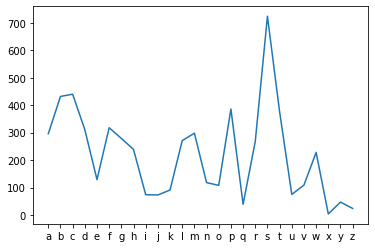

frequency of letters as the 2nd Letter:


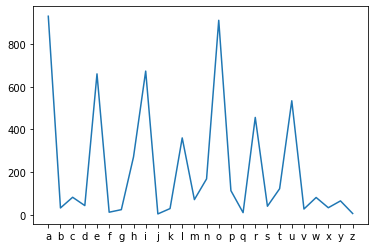

frequency of letters as the 3rd Letter:


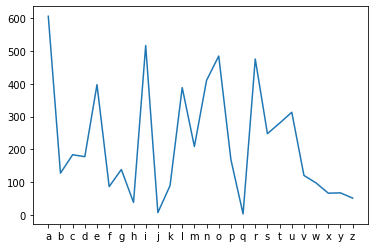

frequency of letters as the 4th Letter:


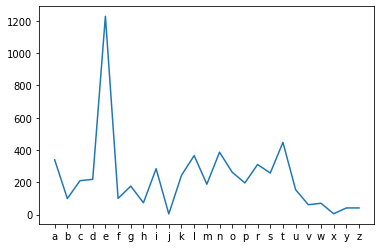

frequency of letters as the 5th Letter:


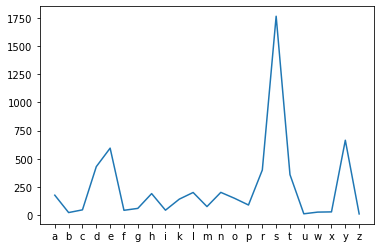

In [49]:
# Plotting the same

"""
Visualizing the data above just for the lulz
"""

for position in range(5):
    print('frequency of letters as the {}:'.format(position_to_letter_mapping[position]))
    lists = sorted(frequency_at_positions[position].items()) # sort alphabetically
    x, y = zip(*lists)
    plt.plot(x, y)
    plt.show()

In [116]:
"""
We know we have to score the words to get the best valid guess
"""

# score based on positional
word_scores_algorithm_2 = {}
for word in words:
    word_score = 0
    position = 0
    for letter in word:
        scores = frequency_at_positions[position]
        word_score += len(words) - scores[letter]
        position += 1
    word_scores_algorithm_2[word] = word_score
    
_sorted_scores = {k: v for k, v in sorted(word_scores_algorithm_2.items(), key=lambda item: item[1])}
list(_sorted_scores.items())[:15]

[('sores', 23683),
 ('sales', 23751),
 ('soles', 23770),
 ('sates', 23859),
 ('sires', 23921),
 ('cares', 23948),
 ('bares', 23956),
 ('cores', 23967),
 ('bores', 23975),
 ('sines', 23986),
 ('sages', 24000),
 ('pares', 24002),
 ('tares', 24012),
 ('canes', 24013),
 ('saves', 24018)]

In [115]:
"""
Let's just normalize the above scores as we did with algorithm 1
"""
max_score_algorithm_2 = word_scores_algorithm_2[max(word_scores_algorithm_2, key=word_scores_algorithm_2.get)]
min_score_algorithm_2 = word_scores_algorithm_2[min(word_scores_algorithm_2, key=word_scores_algorithm_2.get)]

normalized_scores_algorithm_2 = {}

for word in words:
    normalized_scores_algorithm_2[word] = 100 - (word_scores_algorithm_2[word] - min_score_algorithm_2) / (
                max_score_algorithm_2 - min_score_algorithm_2)
    
_sorted_scores = {k: v for k, v in sorted(normalized_scores_algorithm_2.items(), key=lambda item: item[1], reverse=True)}
list(_sorted_scores.items())[:15]

[('sores', 100.0),
 ('sales', 99.9851170934559),
 ('soles', 99.98095863427446),
 ('sates', 99.96147953600351),
 ('sires', 99.94790982709564),
 ('cares', 99.94200043773255),
 ('bares', 99.94024950755089),
 ('cores', 99.9378419785511),
 ('bores', 99.93609104836945),
 ('sines', 99.93368351936967),
 ('sages', 99.93061939155176),
 ('pares', 99.93018165900635),
 ('tares', 99.92799299627927),
 ('canes', 99.92777413000657),
 ('saves', 99.92667979864304)]

<b>So according to algorithm 2, 'sores' is the most disruptive word because it has letters which are most frequent (closest to half of the number of words) at that particular position

<b>Pros of algorithm 2:
<li> Cares about position of letters within the word<br>
<b>Cons of algorithm 2:</b>
<li> Does not penalize repetitions

In [114]:
"""
Since both have pros and cons, what do we do?
Simple, take the average
"""

normalized_scores = {}
for word in words:
    normalized_scores[word] = (normalized_scores_algorithm_1[word] + normalized_scores_algorithm_2[word]) / 2
    
_sorted_scores = {k: v for k, v in sorted(normalized_scores.items(), key=lambda item: item[1], reverse=True)}
list(_sorted_scores.items())[:15]

[('tares', 99.9469774161386),
 ('cares', 99.92195431891784),
 ('tales', 99.92074708912936),
 ('dares', 99.91902878006829),
 ('pares', 99.9155807727729),
 ('rates', 99.91381917582343),
 ('lores', 99.91112818170213),
 ('bares', 99.90823718286259),
 ('nares', 99.90327177423114),
 ('roles', 99.90127919943029),
 ('mares', 99.90017448348857),
 ('cores', 99.89754399082274),
 ('lanes', 99.8961922460838),
 ('dales', 99.89279845305906),
 ('hares', 99.89222231214666)]

<b>Best starting word as per combined algorithm is 'tares'

<h3>Using this holy grail of information</h3>

<b>So we did this for a list of all words, if we want to do it for a list of filtered words, all the logic remains the same

In [101]:
"""
There is literally nothing new in this code
It is just the code used above mushed into a single function so it can be called for a specific list of words
"""


def get_best_word(words):
    # ALGO 1
    scores_algorithm_1 = {}
    for letter in frequencies:
        scores_algorithm_1[letter] = len(words) - frequencies[letter]
    word_scores_algorithm_1 = {}
    for word in words:
        scores = scores_algorithm_1.copy()
        word_score = 0
        for letter in word:
            word_score += scores[letter]
            scores[letter] = len(words)
        word_scores_algorithm_1[word] = word_score

    max_score_algorithm_1 = word_scores_algorithm_1[max(word_scores_algorithm_1, key=word_scores_algorithm_1.get)]
    min_score_algorithm_1 = word_scores_algorithm_1[min(word_scores_algorithm_1, key=word_scores_algorithm_1.get)]
    normalized_scores_algorithm_1 = {}
    for word in words:
        normalized_scores_algorithm_1[word] = round(100 - (word_scores_algorithm_1[word] - min_score_algorithm_1) / (
                max_score_algorithm_1 - min_score_algorithm_1), 3)

    sorted_scores_algorithm_1 = {k: v for k, v in
                                 sorted(normalized_scores_algorithm_1.items(), key=lambda item: item[1], reverse=True)}
    print('Best guesses according to Algorithm 1:')
    print(list(sorted_scores_algorithm_1.items())[:5])

    # ALGO 2
    frequency_at_positions = {}
    for position in range(5):
        frequency_at_positions[position] = {}
    for word in words:
        for position in range(5):
            if word[position] in frequency_at_positions[position]:
                frequency_at_positions[position][word[position]] += 1
            else:
                frequency_at_positions[position][word[position]] = 1
    word_scores_algorithm_2 = {}
    for word in words:
        word_score = 0
        position = 0
        for letter in word:
            scores = frequency_at_positions[position]
            word_score += len(words) - scores[letter]
            position += 1
        word_scores_algorithm_2[word] = word_score

    max_score_algorithm_2 = word_scores_algorithm_2[max(word_scores_algorithm_2, key=word_scores_algorithm_2.get)]
    min_score_algorithm_2 = word_scores_algorithm_2[min(word_scores_algorithm_2, key=word_scores_algorithm_2.get)]
    normalized_scores_algorithm_2 = {}
    for word in words:
        normalized_scores_algorithm_2[word] = round(100 - (word_scores_algorithm_2[word] - min_score_algorithm_2) / (
                max_score_algorithm_2 - min_score_algorithm_2), 3)
    sorted_scores_algorithm_2 = {k: v for k, v in
                                 sorted(normalized_scores_algorithm_2.items(), key=lambda item: item[1], reverse=True)}
    print('Best guesses according to Algorithm 2:')
    print(list(sorted_scores_algorithm_2.items())[:5])

    # ALGO 3
    normalized_scores = {}
    for word in words:
        normalized_scores[word] = round((normalized_scores_algorithm_1[word] + normalized_scores_algorithm_2[word]) / 2,
                                        3)
    sorted_scores = {k: v for k, v in
                     sorted(normalized_scores.items(), key=lambda item: item[1], reverse=True)}
    print('Best guesses overall:')
    print(list(sorted_scores.items())[:5])


In [110]:
"""
WE MAKE A SYSTEM TO PLAY THE GAME, i.e. FILTER OUT WORDS BASED ON THE RULES AND FIND THE BEST GUESS!
"""

"""
I could write some code to read the webpage and get the output 
But I am not going to do that because that's not the point
Just manually update the ouput of each guess in the dictionary 'guesses' below
"""


"""
GREEN - 2
YELLOW - 1
GRAY - 0
"""

"""
Make the guess suggested by the algorithm and update the results as per the legend above. 
You get it. Or atleast I hope you do.
Keep 'guesses' empty when you start and just run this cell.
Once you get the results, put the key as the word you guessed 
If the result is GREY GREEN GREY YELLOW YELLOW just put the value as 02011
Repeat this for each guess you have to make!
"""

# Starting
guesses = {
}

# After 3 guesses it will look like
guesses = {
    'tares': '00100',
    'irony': '01100',
    'dolor': '01022'
}


def guess(guesses):
    filtered_words = words
    print('{} possible words remain!'.format(len(filtered_words)))
    get_best_word(filtered_words)
    
    for guess in guesses:
        print()
        for letter_index in range(len(guess)):
            letter = guess[letter_index]
            result = guesses[guess][letter_index]
            if result == '2':
                filtered_words = [word for word in filtered_words if word[letter_index] == letter]
            if result == '1':
                filtered_words = [word for word in filtered_words if (letter in word and word[letter_index] != letter)]
            if result == '0':
                filtered_words = [word for word in filtered_words if letter not in word]

        print('{} possible words remain!'.format(len(filtered_words)))

        if len(filtered_words) == 0:
            print('Filtered out all words. Something\'s fishy.')
        elif len(filtered_words) == 1:
            print('Guessed the word. It\'s \'{}\''.format(filtered_words[0]))
        elif len(filtered_words) == 2:
            print('Its either \'{}\' or \'{}\''.format(filtered_words[0], filtered_words[1]))
        else:
            get_best_word(filtered_words)

<h3> Let's play today's wordle! (#236 when I'm making this)</h3>

In [111]:
"""
YOU CAN LISTEN TO ALGORITHM 1 OR 2 AS WELL, BUT I'M GOING TO LISTEN TO THE COMBINED ONE
ALL OF THEM WILL WORK THOUGH
"""

# After 0 guesses
guesses = {}     
# After 1 guesses
guesses = {
    'tares': '02011'
}
guess(guesses)
# After 2 guesses
"WE ALREADY DAMN FOUND THE WORD IN 2 GUESSES."
# Okay it's smart and all but we were also lucky today

# HOT DAMN
"""
Wordle 236 2/6

⬛🟩⬛🟨🟨
🟩🟩🟩🟩🟩
"""
print('\nTips hat')

5757 possible words remain!
Best guesses according to Algorithm 1:
[('arose', 100.0), ('raise', 99.967), ('arise', 99.967), ('aloes', 99.967), ('tears', 99.966)]
Best guesses according to Algorithm 2:
[('sores', 100.0), ('sales', 99.985), ('soles', 99.981), ('sates', 99.961), ('sires', 99.948)]
Best guesses overall:
[('tares', 99.947), ('cares', 99.922), ('tales', 99.921), ('dares', 99.919), ('pares', 99.916)]

10 possible words remain!
Best guesses according to Algorithm 1:
[('lapse', 100.0), ('sable', 99.859), ('false', 99.768), ('manse', 99.757), ('cause', 99.713)]
Best guesses according to Algorithm 2:
[('pause', 100.0), ('cause', 99.857), ('masse', 99.857), ('passe', 99.857), ('false', 99.714)]
Best guesses overall:
[('pause', 99.853), ('cause', 99.785), ('lapse', 99.785), ('false', 99.741), ('manse', 99.736)]

Tips hat
